In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math
#import optuna
#import lightgbm as lgb
import re
import plotly.express as px
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



In [2]:
file_path = r'C:\Users\nusha\Desktop\Portfolio\notebooks\\'

df = pd.read_csv(file_path + 'train.csv')

test = pd.read_csv(file_path + 'test.csv')
submission = pd.read_csv(file_path + 'sample_submission.csv') 
original = pd.read_csv(file_path + 'machine failure.csv')

display(df.head(),test.head())

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [3]:
type_mapping = {'L': 0, 'M': 1, 'H': 2}

df['Type_numeric'] = df['Type'].map(type_mapping)
test['Type_numeric'] = test['Type'].map(type_mapping)



In [4]:
display(df.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
 14  Type

None

None

In [5]:
print('df length: ', df.shape)

print('Number of unique values and data type of the column: ')
for column in df.columns:
    unique_values = df[column].unique()
    column_type = df[column].dtype
    if len(unique_values) < 20:
        print(f"{column}: {column_type},  {len(unique_values)}, {unique_values} " )
        
    else:
        print(f"{column}: {column_type},  {len(unique_values)}")

df length:  (136429, 15)
Number of unique values and data type of the column: 
id: int64,  136429
Product ID: object,  9976
Type: object,  3, ['L' 'M' 'H'] 
Air temperature [K]: float64,  95
Process temperature [K]: float64,  81
Rotational speed [rpm]: int64,  952
Torque [Nm]: float64,  611
Tool wear [min]: int64,  246
Machine failure: int64,  2, [0 1] 
TWF: int64,  2, [0 1] 
HDF: int64,  2, [0 1] 
PWF: int64,  2, [0 1] 
OSF: int64,  2, [0 1] 
RNF: int64,  2, [0 1] 
Type_numeric: int64,  3, [0 1 2] 


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,136429.0,68214.000000,39383.804275,0.0,34107.0,68214.0,102321.0,136428.0
Air temperature [K],136429.0,299.862776,1.862247,295.3,298.3,300.0,301.2,304.4
Process temperature [K],136429.0,309.941070,1.385173,305.8,308.7,310.0,310.9,313.8
Rotational speed [rpm],136429.0,1520.331110,138.736632,1181.0,1432.0,1493.0,1580.0,2886.0
Torque [Nm],136429.0,40.348643,8.502229,3.8,34.6,40.4,46.1,76.6
Tool wear [min],136429.0,104.408901,63.965040,0.0,48.0,106.0,159.0,253.0
Machine failure,136429.0,0.015744,0.124486,0.0,0.0,0.0,0.0,1.0
TWF,136429.0,0.001554,0.039389,0.0,0.0,0.0,0.0,1.0
HDF,136429.0,0.005160,0.071649,0.0,0.0,0.0,0.0,1.0
PWF,136429.0,0.002397,0.048899,0.0,0.0,0.0,0.0,1.0


In [7]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

# profile.to_file("report.html")

# profile.to_notebook_iframe()

In [8]:
numeric_df = df.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()
correlation_matrix

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_numeric
id,1.000000,-0.005338,-0.002396,0.004419,-0.001968,-0.001790,0.001500,-0.000475,-0.000680,0.003275,0.002114,0.000175,-0.004375
Air temperature [K],-0.005338,1.000000,0.856080,0.016545,-0.006773,0.016994,0.067744,0.003826,0.100454,0.007967,0.007842,0.004815,-0.001323
Process temperature [K],-0.002396,0.856080,1.000000,0.011263,-0.006298,0.012777,0.030966,0.004459,0.041454,0.003871,0.005337,0.004399,-0.004041
Rotational speed [rpm],0.004419,0.016545,0.011263,1.000000,-0.779394,0.003983,-0.060868,-0.005765,-0.081996,0.053948,-0.061376,-0.003410,0.001396
Torque [Nm],-0.001968,-0.006773,-0.006298,-0.779394,1.000000,-0.003148,0.145793,0.012983,0.100773,0.050289,0.108765,0.007986,-0.001454
Tool wear [min],-0.001790,0.016994,0.012777,0.003983,-0.003148,1.000000,0.056448,0.046470,0.011709,0.007624,0.063604,-0.002071,0.006266
Machine failure,0.001500,0.067744,0.030966,-0.060868,0.145793,0.056448,1.000000,0.311919,0.564507,0.383941,0.494668,0.001428,-0.011551
TWF,-0.000475,0.003826,0.004459,-0.005765,0.012983,0.046470,0.311919,1.000000,0.010145,0.039927,0.036041,0.002044,0.003184
HDF,-0.000680,0.100454,0.041454,-0.081996,0.100773,0.011709,0.564507,0.010145,1.000000,0.046680,0.067149,0.000885,0.001698
PWF,0.003275,0.007967,0.003871,0.053948,0.050289,0.007624,0.383941,0.039927,0.046680,1.000000,0.090016,0.000827,-0.000208


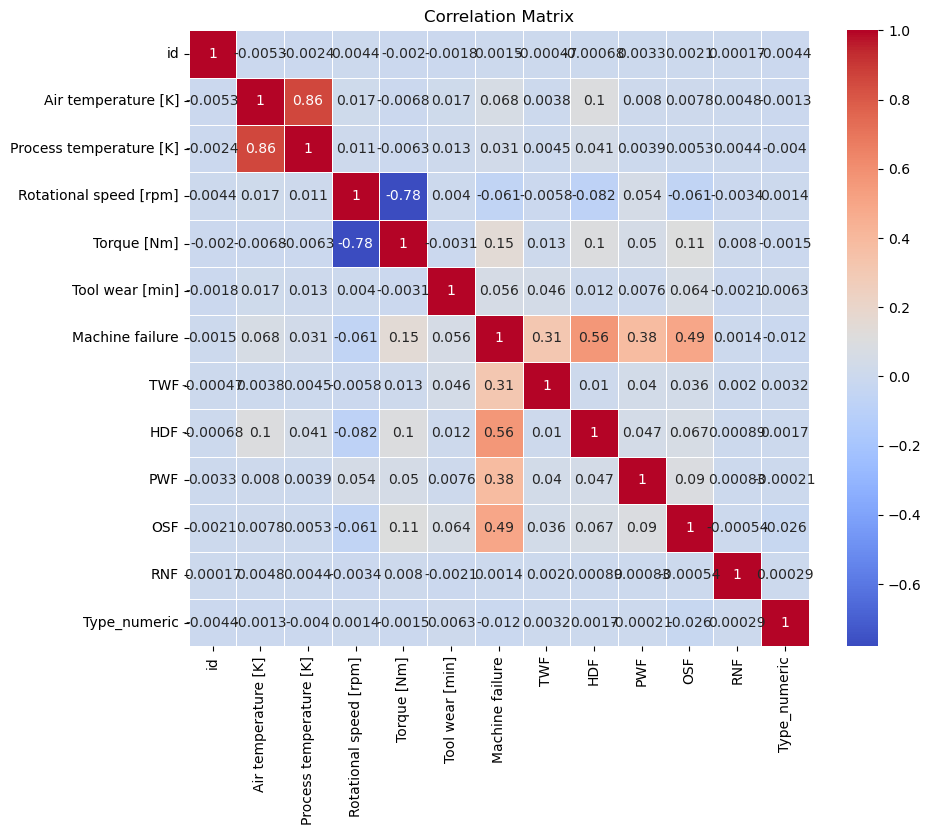

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
# sns.pairplot(numeric_df, hue='Machine failure')

In [11]:
cols=['id', 'Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]', 'Machine failure', 'Type_numeric']


In [ ]:
selected_df = df[cols] 

sns.pairplot(selected_df, hue='Machine failure')

In [ ]:
empty_rows_count_df = df.isna().all(axis=1).sum()
empty_rows_count_test = test.isna().all(axis=1).sum()
print(f"Empty rows in DataFrame: {empty_rows_count_df}, Empty rows in DataFrame: {empty_rows_count_test} ")

In [ ]:
# print('Check for completely empty strings:')
# display('df:' , df.applymap(lambda x: x == '').sum(),'test: ', test.applymap(lambda x: x == '').sum())


In [ ]:
duplicate_rows_count = df.duplicated().sum()

print(f"Number of duplicate rows in DataFrame: {duplicate_rows_count}")

In [ ]:
def count_duplicate_rows(df):
    duplicate_rows = df[df.duplicated()]
    
    if not duplicate_rows.empty:
        print("Duplicate rows found in the dataframe.")
        count = len(duplicate_rows)
        print(f"Count of duplicate rows: {count}.")
    else:
        print("No duplicate rows found in the dataframe.")

    return df

df = count_duplicate_rows(df)
#test = count_duplicate_rows(test)